## This will be the codebase for the dictionary learning portion

In [1]:
from sklearn.feature_extraction import image as image_extractor
from sklearn.decomposition import MiniBatchDictionaryLearning
from skimage import io
import matplotlib.pyplot as plt
from scipy import ndimage
import csv
import numpy as np
import distutils
from distutils import util

### Read the image

In [2]:
image = io.imread("0.210521.png",as_gray=True)

Load as grayscale image (because we know that the image has no color), and also convert to floating point, to operate on real numbers, not on integers.

In [3]:
image.shape

(260, 346)

In [4]:
image.dtype

dtype('float64')

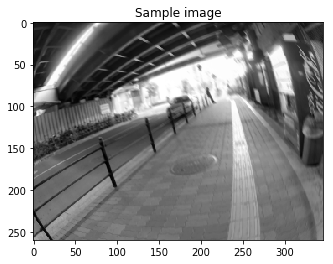

In [5]:
plt.imshow(image, cmap='gray')
plt.title('Sample image')
plt.show()

### Calculate the X and Y derivative using sobel operator. This is very good with edge detection

In [6]:
image_x = ndimage.sobel(image, axis=0)
image_y = ndimage.sobel(image, axis=1)

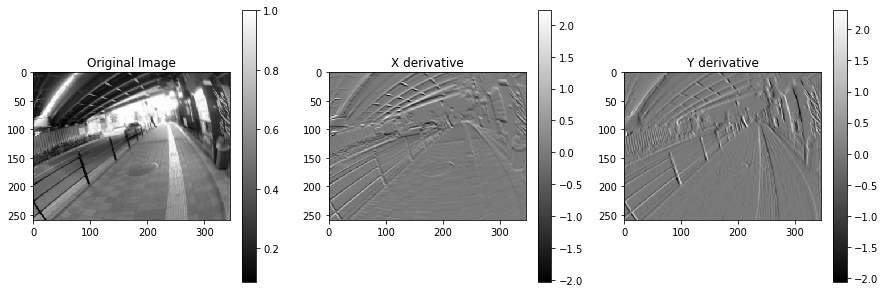

In [7]:
fig, (ax1,ax2, ax3) = plt.subplots(1, 3, figsize = (15, 5), sharex = True)

p1 = ax1.imshow(image, cmap='gray')
ax1.set_title('Original Image')
plt.colorbar(p1,ax=ax1)

p2 = ax2.imshow(image_x, cmap='gray')
ax2.set_title('X derivative')
plt.colorbar(p2,ax=ax2)

p3 = ax3.imshow(image_y, cmap='gray')
ax3.set_title('Y derivative')
plt.colorbar(p3,ax=ax3)

plt.show()

In [8]:
patch_size = (7, 7)
max_patches = 30000

In [9]:
patches_x = image_extractor.extract_patches_2d(image_x, patch_size, max_patches)
patches_y = image_extractor.extract_patches_2d(image_y, patch_size, max_patches)

In [10]:
patches_x.shape

(10000, 7, 7)

In [11]:
"""
patches_xs = patches_x.reshape(patches_x.shape[0], -1)
patches_ys = patches_y.reshape(patches_y.shape[0], -1)
patches_xs.shape
"""

'\npatches_xs = patches_x.reshape(patches_x.shape[0], -1)\npatches_ys = patches_y.reshape(patches_y.shape[0], -1)\npatches_xs.shape\n'

## Create the event histogram

In [12]:
num_time_slices = 3
img_pos = np.zeros((image.shape[0], image.shape[1], num_time_slices), np.float64)
img_neg = np.zeros((image.shape[0], image.shape[1], num_time_slices), np.float64)

In [13]:
# read the file and store it in different arrays 
timestamp = []
x = []
y = []
pol = []

with open('event_data.csv') as csvfile:
    event_file = csv.reader(csvfile, delimiter=',')
    next(event_file)
    for row in event_file:
        if len(row) == 0:
            continue; # while writing, an additional alternative empty row is written in the excel. so skippping
        x.append(int(row[0]))
        y.append(int(row[1]))
        timestamp.append(float(row[2]))
        pol.append(distutils.util.strtobool(row[3]))
        
assert len(x) == len(y) == len(pol) == len(timestamp)

In [14]:
total_num_events = len(x)

In [15]:
total_num_events

39969

Convert to numpy arrays

In [16]:
x = np.array(x)
y = np.array(y)
timestamp = np.array(timestamp)
pol = np.array(pol)

In [17]:
t_max = np.amax(timestamp)
t_min = np.amin(timestamp)
t_range = t_max - t_min
dt_cell = t_range / num_time_slices
t_edges = np.linspace(t_min,t_max,num_time_slices+1) # boundaries of the cells; not needed

# Specify bin edges in each dimension
bin_edges = (np.linspace(0,image.shape[0],image.shape[0]+1), 
             np.linspace(0,image.shape[1],image.shape[1]+1), t_edges)

'\nyxt = np.transpose(np.array([y, x, timestamp])) # all events\nvoxelgrid, edges = np.histogramdd(yxt, bins=bin_edges)\n'

In [ ]:
# one voxel grid for all events (both polarities)
yxt = np.transpose(np.array([y, x, timestamp]))
voxelgrid, edges = np.histogramdd(yxt, bins=bin_edges)
voxelgrid.shape

In [19]:
# positive events only
idx_pos = pol==0
yxt_pos = np.transpose(np.array([y[idx_pos], x[idx_pos], timestamp[idx_pos]]))
voxelgrid_pos, _ = np.histogramdd(yxt_pos, bins=bin_edges)

# positive events only
idx_neg = pol!=0
yxt_neg = np.transpose(np.array([y[idx_neg], x[idx_neg], timestamp[idx_neg]]))
voxelgrid_neg, _ = np.histogramdd(yxt_neg, bins=bin_edges)

In [20]:
voxelgrid_pos.shape

(260, 346, 3)

It is a bit more complicated: I think it is better that the chuncks have equal time span $\Delta t$, rather than equal number of events. See the code from Ex 2 in the course to create the voxel grids.

In [21]:
"""
fig, axs = plt.subplots(3, 2, figsize=(15, 15))
fig.suptitle('Histogram of negative events')

for i in range(num_time_slices):
    plt.sca(axs[int(i/2),i%2])
    plt.imshow(voxelgrid_neg[:,:,i], cmap='gray_r')
    plt.colorbar()

axs.flat[-1].set_visible(False)

plt.show()
"""

"\nfig, axs = plt.subplots(3, 2, figsize=(15, 15))\nfig.suptitle('Histogram of negative events')\n\nfor i in range(num_time_slices):\n    plt.sca(axs[int(i/2),i%2])\n    plt.imshow(voxelgrid_neg[:,:,i], cmap='gray_r')\n    plt.colorbar()\n\naxs.flat[-1].set_visible(False)\n\nplt.show()\n"

In [22]:
"""
fig, axs = plt.subplots(3, 2, figsize=(15, 15))
fig.suptitle('Histogram of positive events')

for i in range(num_time_slices):
    plt.sca(axs[int(i/2),i%2])
    plt.imshow(voxelgrid_pos[:,:,i], cmap='gray_r')
    plt.colorbar()
    
axs.flat[-1].set_visible(False)

plt.show()
"""

"\nfig, axs = plt.subplots(3, 2, figsize=(15, 15))\nfig.suptitle('Histogram of positive events')\n\nfor i in range(num_time_slices):\n    plt.sca(axs[int(i/2),i%2])\n    plt.imshow(voxelgrid_pos[:,:,i], cmap='gray_r')\n    plt.colorbar()\n    \naxs.flat[-1].set_visible(False)\n\nplt.show()\n"

Stack the spatial gradient and the temporal derivative (events) on a single WxHxZ array to select the patches together on all Z slices with one single call to `extract_patches_2d`

In [26]:
image_gradient = np.concatenate((np.expand_dims(image_x, axis=2), np.expand_dims(image_y, axis=2)), axis=2)
voxgrids = np.concatenate((voxelgrid_pos,voxelgrid_neg), axis=2)
data = np.concatenate((image_gradient, voxgrids), axis=2)
del image_gradient
del voxgrids

In [27]:
data.shape

(260, 346, 8)

In [28]:
data_patches = image_extractor.extract_patches_2d(data, patch_size, max_patches)
data_patches.shape

(10000, 7, 7, 8)

In [29]:
idx_patch = 100

(7, 7, 8)


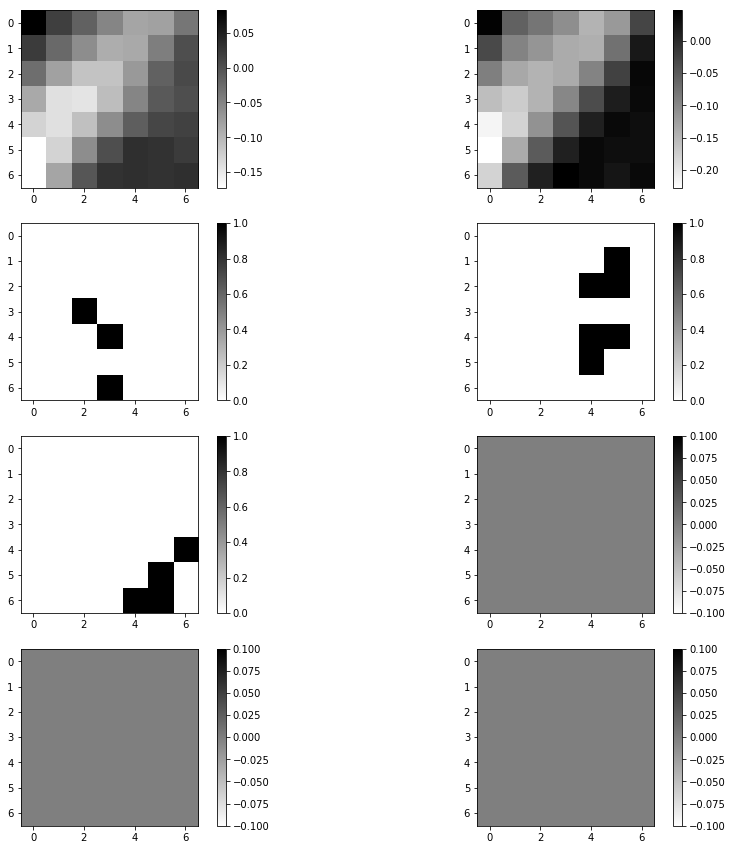

In [35]:
ww = data_patches[idx_patch].reshape(patch_size[0],patch_size[1],-1)
print( ww.shape )
fig, axs = plt.subplots(num_time_slices+1, 2, figsize=(15, 15))
for i in range(num_time_slices*2 + 2):
    plt.sca(axs[int(i/2),i%2])
    plt.imshow(ww[:,:,i], cmap='gray_r')
    plt.colorbar()
#axs.flat[-1].set_visible(False)  # to hide last plot
plt.show()

In [30]:
data_patches = data_patches.reshape(data_patches.shape[0], -1)

In [31]:
data_patches.shape

(10000, 392)

In [33]:
print('Learning the dictionary...')
dico = MiniBatchDictionaryLearning(n_components=100, alpha=1, n_iter=500)
V = dico.fit(data_patches).components_

Learning the dictionary...


/home/ggb/.local/lib/python2.7/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=8.145e-03, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.788e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/home/ggb/.local/lib/python2.7/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=4.512e-03, with an active set of 6 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/home/ggb/.local/lib/python2.7/site-packages/sklearn/linear_model/least_angle.py:337: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 20 iterations, alpha=4.487e-03, previous alph

In [34]:
V.shape

(100, 392)

In [36]:
patches_x.shape

(10000, 7, 7)

Visualize the atoms:

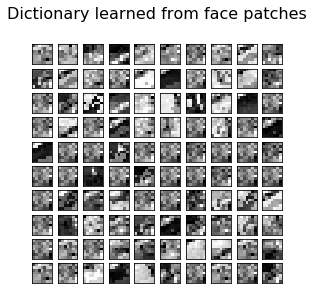

In [40]:
plt.figure(figsize=(4.2, 4))
for i, comp in enumerate(V[:100]):
    plt.subplot(10, 10, i + 1)
    atom = comp.reshape(patch_size[0],patch_size[0],-1)
    plt.imshow(atom[:,:,2], cmap=plt.cm.gray_r,
               interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
plt.suptitle('Dictionary learned from face patches\n', fontsize=16)
plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)

TO DO: 
- use bilinear voting instead of nearest neighbor (when computing voxel grids)
- reconstruction with the learned dictionary
- visualize better the atoms
- are the gx,gy dominating the largest components (best atoms)?
- test with a single voxel grid (with polarity), instead of two (Ep,En)